In [1]:
import os
import os.path as op
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from scipy.ndimage import measurements

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

import mne
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm
from mne.decoding import CSP
from library import helpers, config

# TODO: extract values for manuscript:
# - latalpha_cbp_2ndlvl_pval
# - 

In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
# %%
def get_epos(subID, epo_part, signaltype, condition, event_dict):
    if signaltype == 'uncollapsed':
        fname = op.join(config.path_rejepo, subID + '-' + epo_part +
                        '-postica-rejepo' + '-epo.fif')
    elif signaltype in ['collapsed']:
        fname = op.join(config.path_epos_sorted, epo_part, signaltype,
                        subID + '-epo.fif')
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)

def get_sensordata(subID, epo_part, signaltype, conditions, event_dict):
    epos_dict = defaultdict(dict)
    for cond in conditions:
        epos_dict[cond] = get_epos(subID,
                                   epo_part=epo_part,
                                   signaltype=signaltype,
                                   condition=cond,
                                   event_dict=event_dict)

    times = epos_dict[conditions[0]][0].copy().times

    # Setup data:
    X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
    n_ = {cond: len(epos_dict[cond]) for cond in conditions}

    times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X_epos, y, times_n


def load_avgtfr(subID, condition, pwr_style='induced', 
                epo_part='fulllength', baseline=None, mode=None): 
    fpath = op.join(config.paths['05_tfrs'], pwr_style, 'tfr_lists', epo_part)
    fname = op.join(fpath, subID + '-collapsed-avgTFRs-tfr.h5')
    tfr_ = mne.time_frequency.read_tfrs(fname, condition=condition)
    if baseline is not None:
        tfr_.apply_baseline(baseline=baseline, mode=mode)
    return tfr_


def plot_tfr_side(ax, tfr, picks, cbar=True, tmin=None, tmax=None, 
                  vmin=None, vmax=None, title='', cmap='RdBu_r', mask=None):
        ha = tfr.copy().crop(tmin, tmax).plot(axes=ax, 
                                      show=False,
                                      baseline=(-1.1,-0.9),
                                      mode='mean', 
                                      colorbar=cbar,
                                      picks=picks, 
                                      combine='mean', 
                                      title=title, 
                                      #vmax=vmax, 
                                      #vmin=vmin, 
                                      cmap=cmap,
                                      mask=mask)
        ytick_range = ax.get_ylim()
        ytick_vals = np.arange(*np.round(ytick_range), 2)
        ax.yaxis.set_ticks(ytick_vals)
        ax.axvspan(0, 0.2, color='grey', alpha=0.3)
        ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
        ax.vlines((-0.8, 0, 0.2, 2.2), ymin=-1000, ymax=10000, linestyles='dashed')
        #ax.set_title('uV^2/Hz')
        return ha

def get_lateralized_power_difference(pwr_, picks_contra, picks_ipsi):
    if not len(picks_contra) == len(picks_ipsi):
        raise ValueError('Picks must be of same length.')
    pwr_diff = pwr_.copy().pick_channels(picks_contra, ordered=True)
    pwr_ordered_chans = pwr_.copy().reorder_channels(picks_contra + picks_ipsi)
    # keep flexible to use for data with 3 (AvgTFR) and 4 (EpoTFR) dimensions: 
    d_contra = pwr_ordered_chans._data[..., :len(picks_contra), :, :]
    d_ipsi = pwr_ordered_chans._data[..., len(picks_contra):, :, :]
    pwr_diff._data = d_contra - d_ipsi
    return pwr_diff


def run_cbp_test(data, p_initial = 0.05, p_thresh = 0.05):
    # number of permutations to run
    n_permutations = 1000 
    # set initial threshold
    p_initial = p_initial
    # set family-wise p-value
    p_thresh = p_thresh
    adjacency = None
    tail = 0.  # for two sided test

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = permutation_cluster_1samp_test(
        data, threshold=threshold, n_jobs=config.n_jobs, verbose=True, tail=tail,
        step_down_p=0.05, adjacency=adjacency,
        n_permutations=n_permutations, seed=42)

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)


def plot_cbp_result(ax, T_obs, clusters, cluster_p_values, p_thresh, 
                        cbp_times=None, times_full=None):
    if cbp_times is None:
        if times_full is None: 
            times_full = range(len(T_obs))
        cbp_times = times_full
    if times_full is None: 
        times_full = cbp_times
    y_max = np.max(np.abs(T_obs)) * np.array([-1.1, 1.1])
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] < p_thresh:
            h1 = ax.axvspan(cbp_times[c[0]], cbp_times[c[- 1]],
                            color='r', alpha=0.3)
    hf = ax.plot(cbp_times, T_obs, 'g')
    ax.hlines(0, times_full[0], times_full[-1])
    ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1, prop={'size': 9})
    ax.set(xlabel="Time (s)", ylabel="T-values",
            ylim=y_max, xlim=times_full[np.array([0,-1])])
    #fig.tight_layout(pad=0.5)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    ax.vlines([-0.8, 0,0.2,2.2], *y_max, linestyles='--', colors='k',
                    linewidth=1., zorder=1)
    #ax.set_aspect(0.33)
    ax.set_title('')
    #ax.set_aspect('auto', adjustable='datalim')
    #ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)


def plot_main_eff(cond, cond_dict, data, ax, n_boot=1000):
    sns.lineplot(x='time', y='pwr', hue=cond, data=data, n_boot=n_boot, 
                 palette=[config.colors[l] for l in cond_dict[cond]], ax=ax)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(-1.1, 2.3), ylim=ytick_range)
    ax.set_ylabel('V$^2$')
    ax.set_xlabel('Time (s)')
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
    ax.vlines((-0.8, 0, 0.2, 2.2), ymin=ytick_range[0], ymax=ytick_range[1], 
            linestyles='dashed')
    ax.hlines(0, xmin=-1.1, xmax=2.3)



def get_tfr(epos, picks='all', average=True, freqs=None):
    if freqs is None:
        freqs = np.concatenate([np.arange(6, 26, 1)])  # , np.arange(16,30,2)])
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power = mne.time_frequency.tfr_morlet(epos, picks=picks, freqs=freqs,
                                          n_cycles=n_cycles, use_fft=True,
                                          return_itc=False, average=average,
                                          decim=1, n_jobs=-2)
    return power


def get_mean_pwrdiff_per_trial(subID, freqs_to_avg=np.arange(8,13),
                               t_start=None, t_stop=None, pwr_style='induced',
                               epo_part='fulllength', 
                               picks=config.chans_CDA_all):
    fpath = op.join(config.paths['03_preproc-pooled'], epo_part, 'collapsed')
    epos_ = helpers.load_data(f'{subID}-{epo_part}-collapsed',
                              fpath, '-epo')
    
    # Shift time, so that 0 == Stimulus Onset:
    epos_ = epos_.shift_time(-config.times_dict['cue_dur'])
    
    if pwr_style == 'induced':
        epos_ = epos_.subtract_evoked()

    event_dict = helpers.get_event_dict(epos_.event_id)

    sub_dfs = list()

    for load in ['LoadLow', 'LoadHigh']:
        for ecc in ['EccS', 'EccM', 'EccL']:
            epos_cond = epos_[event_dict[load]][event_dict[ecc]]
            # Get TFRs and calc lat power:
            tfrs_cond = get_tfr(epos_cond,
                                   picks=picks, 
                                   average=False, 
                                   freqs=freqs_to_avg)
            tfrs_cond.apply_baseline(baseline=(-(config.times_dict['cue_dur']+0.3), 
                                               -(config.times_dict['cue_dur']+0.1)), 
                                     mode='mean')
            tfr_lat = get_lateralized_power_difference(tfrs_cond, 
                                                       config.chans_CDA_dict['Contra'], 
                                                       config.chans_CDA_dict['Ipsi'])
            # Crop to cluster times: 
            tfr_lat.crop(t_start, t_stop)
            tfr_lat_df = tfr_lat.to_data_frame()
            tfr_lat_df = tfr_lat_df.loc[:, ['epoch'] + tfr_lat.ch_names]
            tfr_lat_df = tfr_lat_df.groupby('epoch').agg('mean').reset_index()
            tfr_lat_df['mean_pwr_diff'] = tfr_lat_df.loc[:, tfr_lat.ch_names].mean(axis=1)
            tfr_lat_df['c_StimN'] = load
            tfr_lat_df['c_Ecc'] = ecc
            tfr_lat_df['trial_num'] = tfr_lat_df.epoch + 1 # correcting for 0 indexing in python
            tfr_lat_df = tfr_lat_df.drop('epoch', axis=1)
            
            # store in list
            sub_dfs.append(tfr_lat_df)

    sub_df = pd.concat(sub_dfs, axis=0)
    sub_df['subID'] = subID
    return(sub_df)


def get_condition_pwrdiff_df(factor, cond_dict, sub_list_str, pwr_style="induced", epo_part="fulllength"):
    df_list = list()
    for cond in cond_dict[factor]:
        tfr_list = [load_avgtfr(subID, cond, pwr_style, epo_part, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                            -(config.times_dict['cue_dur']+0.1)), 
                    mode='mean') for subID in sub_list_str]

        diffs_ = [get_lateralized_power_difference(tfr, 
                                                config.chans_CDA_dict['Contra'], 
                                                config.chans_CDA_dict['Ipsi']) for 
                tfr in tfr_list]

        frqs_idx = [(8 <= diffs_[0].freqs) & (diffs_[0].freqs <= 13)]
        diffs_mean = [d.data[:, frqs_idx[0], :].mean(axis=(0, 1)) for d in diffs_]
        plt_df = pd.DataFrame(np.array(diffs_mean).swapaxes(1, 0),
                              columns=sub_list_str)
        plt_df['time'] = times
        plt_df[factor] = cond
        df_list.append(plt_df)

    df_load_concat = pd.concat(df_list)
    df_load_long = df_load_concat.melt(id_vars=['time', factor], 
                                       var_name='subID', 
                                       value_name='pwr')
    return(df_load_long)

## Loading the TFRs from disc

Running the next two cells will take quite long. Then you have the TFRs in memory and can fairly quickly work with them. 


In [4]:
#%%
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

part_epo = 'fulllength'
pwr_style = 'induced'  # 'evoked' # 
cond_dict = {'Load': ['LoadLow', 'LoadHigh'], 
             'Ecc': ['EccS', 'EccM', 'EccL']}


#%% get list with avg TFRs for all trials and conditions: !!! THIS BLOCK TAKES AGES
tfr_list = [load_avgtfr(subID, 'all', pwr_style, part_epo, 
                        baseline=(-(config.times_dict['cue_dur']+0.3), 
                                  -(config.times_dict['cue_dur']+0.1)), 
                        mode='mean') 
            for subID in sub_list_str]

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/

In [5]:
#%% get dict with avg TFRs per load and eccentricity condition: !!! THIS BLOCK TAKES EVEN LONGER
all_conds = [c for fac in cond_dict for c in cond_dict[fac]]
tfr_by_cond = {cond: [load_avgtfr(subID, cond, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                                -(config.times_dict['cue_dur']+0.1)), 
                    mode='mean') 
                    for subID in sub_list_str]
               for cond in all_conds}

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/

Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S07-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptm

Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S07-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S08-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S09-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptm

In [33]:
# Calculate the grand average:
grand_avgtfr_all = mne.grand_average(tfr_list)

#%% Set up params:
times = grand_avgtfr_all.times
freqs = grand_avgtfr_all.freqs



Identifying common channels ...


First, we plot the TFR per "hemisphere" (i.e., the ROI on the contralateral and the ipsilateral side);

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


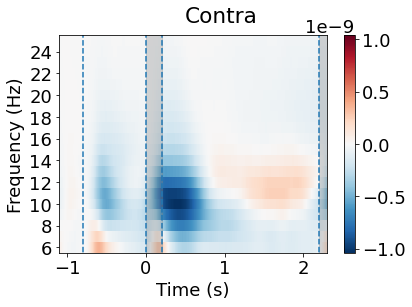

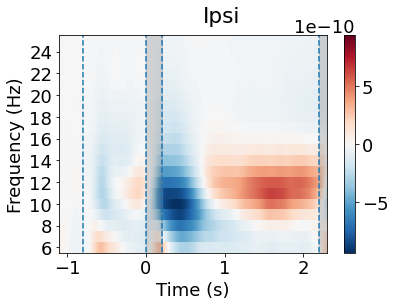

In [7]:
# Plot TF diag per hemisphere across all conditions:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams['font.size'] = 18
for side in ['Contra', 'Ipsi']:
    fig, ax = plt.subplots(1, figsize=(6,4))
    tf_contra = plot_tfr_side(ax, grand_avgtfr_all, picks=config.chans_CDA_dict[side], 
                tmin=-1.1, tmax=2.3, title=side, cbar=True, 
                vmin=-6e-10, vmax=6e-10)

    # Save it: 
    fpath = op.join(config.paths["plots"], 'TFR', part_epo)
    helpers.chkmk_dir(fpath)
    fname = op.join(fpath, f'grandavgTFR_{side}.svg')
    fig.savefig(fname, bbox_inches="tight")

Next step: we calculate the lateralized TFR (i.e., the difference between the two hemispheres):

In [8]:
#%% Calculate the difference between the hemispheres:
diff_avgtfr_all = get_lateralized_power_difference(grand_avgtfr_all, 
                                                 config.chans_CDA_dict['Contra'], 
                                                 config.chans_CDA_dict['Ipsi'])


Applying baseline correction (mode: mean)


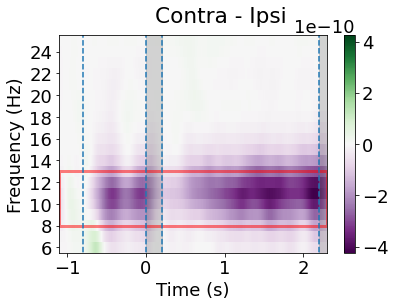

In [9]:
fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_avgtfr_all, picks='all', 
            tmin=-1.1, tmax=2.3, title='Contra - Ipsi', cbar=True, 
            vmin=-4e-10, vmax=4e-10, cmap='PRGn')

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference.svg')
fig.savefig(fname, bbox_inches="tight")

# Create version with red box around classical alpha range (8-12Hz):
rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=3, edgecolor='r', facecolor='none', alpha=0.5)
ax.add_patch(rect)
# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference_classAlpha.svg')
fig.savefig(fname, bbox_inches="tight")

We run a CBP test to produce a masked (thresholded) version of this plot, showing only the significant clusters (p <.05):

In [12]:
#%% Get the difference per subject: 

diffs_avgtfr_all = [get_lateralized_power_difference(tfr, 
                                                   config.chans_CDA_dict['Contra'], 
                                                   config.chans_CDA_dict['Ipsi']) for 
                    tfr in tfr_list]

cropped_data = np.array([d.copy().crop(-1.1, 2.3).data.mean(axis=0) for d in diffs_avgtfr_all])
adjacency = mne.stats.combine_adjacency(*cropped_data.shape[-2:])
threshold = None  # let MNE calc threshold
n_permutations = 1000  
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(cropped_data, n_permutations=n_permutations,
                                   threshold=threshold, tail=0,
                                   adjacency=adjacency,
                                   out_type='mask', verbose=True,
                                   n_jobs=-2)

T_obs_mask = np.full(T_obs.shape, False)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_mask[c] = True

Using a threshold of 2.085963
stat_fun(H1): min=-4.681591 max=3.339622
Running initial clustering
Found 13 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


Applying baseline correction (mode: mean)


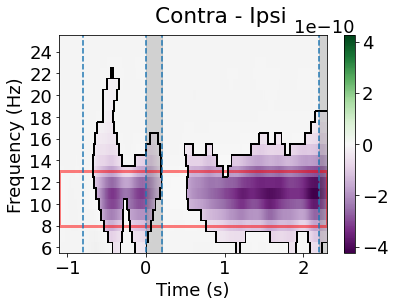

In [13]:
fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_avgtfr_all, picks='all', 
            tmin=-1.1, tmax=2.3, title='Contra - Ipsi', cbar=True, 
            vmin=-4e-10, vmax=4e-10, cmap='PRGn', mask=T_obs_mask)

# Add red box around classical alpha range (8-12Hz):
rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=3, edgecolor='r', facecolor='none', alpha=0.5)
ax.add_patch(rect)
# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference_classAlpha_masked.svg')
fig.savefig(fname, bbox_inches="tight")

We produce one of these plots per participant to check for consistency:

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


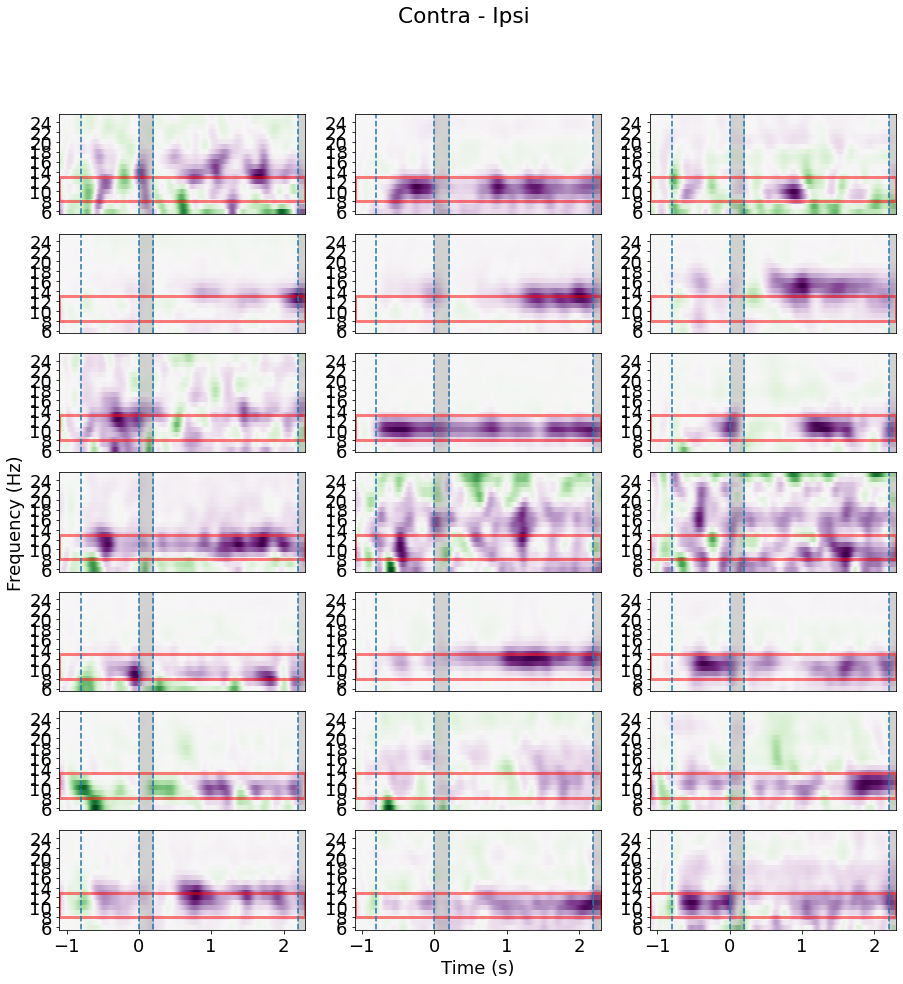

In [14]:



##############################################################################################
#%% Make single subject plots:
fig, ax = plt.subplots(7,3, figsize=(15,15))
for tfr_, ax_ in zip(diffs_avgtfr_all, ax.reshape(-1)):
    plot_tfr_side(ax_, tfr_, picks='all', 
            tmin=-1.1, tmax=2.3, title='Contra - Ipsi', cbar=False, 
            cmap='PRGn')
    rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=3, edgecolor='r', facecolor='none', alpha=0.5)
    ax_.add_patch(rect)
    ax_.xaxis.label.set_visible(False)
    ax_.yaxis.label.set_visible(False)
for ax_ in ax[:-1].reshape(-1):
    ax_.xaxis.set_visible(False)
ax[3,0].yaxis.label.set_visible(True)
ax[6,1].xaxis.label.set_visible(True)

# Save it: 
# fpath = op.join(config.paths["plots"], 'TFR', part_epo)
# helpers.chkmk_dir(fpath)
# fname = op.join(fpath, 'singlesubs_avgTFR_Difference.png')
# fig.savefig(fname, bbox_inches="tight")

Now we plot the difference (in lateralized power) between the two memory load conditions (high  vs low load). According to Sauseng et al. (2009) we should see stronger (more negative) alpha lateralization for the higher memory load:

Identifying common channels ...
Identifying common channels ...
Applying baseline correction (mode: mean)


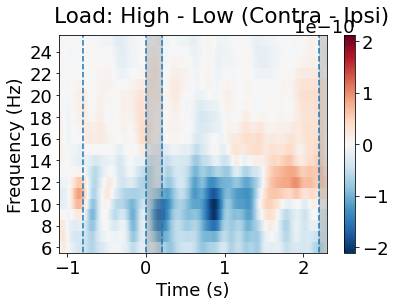

In [15]:
# Calc overall difference between high and low load:
load = 'LoadLow'
side = 'Ipsi'
ga = defaultdict(mne.EvokedArray)
for load in ['LoadHigh', 'LoadLow']:
    tmp = tfr_by_cond[load]
    ga[load] = mne.grand_average(tmp)

diff_ga_data = ga['LoadHigh'].data - ga['LoadLow'].data

info = ga['LoadHigh'].info
diff_ga = mne.time_frequency.AverageTFR(info, diff_ga_data, times, freqs, nave=21)

diff_diff = get_lateralized_power_difference(diff_ga, config.chans_CDA_dict['Contra'], 
                                                      config.chans_CDA_dict['Ipsi'])

fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_diff, picks=config.chans_CDA_dict['Contra'], 
            tmin=-1.1, tmax=2.3, title="Load: High - Low (Contra - Ipsi)", cbar=True, 
            vmin=-6e-10, vmax=6e-10)

We run a quick CBP test to check if anything in this plot is significant:

In [31]:
tt = dict()
for load in ['LoadHigh', 'LoadLow']:
    tmp = tfr_by_cond[load]
    tt[load] = [get_lateralized_power_difference(t, config.chans_CDA_dict['Contra'], 
                                                      config.chans_CDA_dict['Ipsi']) for t in tmp]
ddd = np.array([(h.data - l.data).mean(0) for h,l in zip(tt['LoadHigh'], tt['LoadLow'])])
adjacency = mne.stats.combine_adjacency(*ddd.shape[-2:])
threshold = None  # let MNE calc threshold
n_permutations = 1000  
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(ddd, n_permutations=n_permutations,
                                   threshold=threshold, tail=0,
                                   adjacency=adjacency,
                                   out_type='mask', verbose=True,
                                   n_jobs=-2)
print(f"Test found {np.sum(cluster_p_values < 0.05)} significant clusters (p<.05).")

Using a threshold of 2.085963
stat_fun(H1): min=-3.960081 max=2.930283
Running initial clustering
Found 19 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Test found 0 significant clusters (p<.05).


This does not seem to be the case. Maybe if we average all alpha frequencies?

Now we extract the mean power in the alpha range (8-13Hz) over time and plot it:

stat_fun(H1): min=-4.295639 max=0.736753
Running initial clustering
Found 2 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.


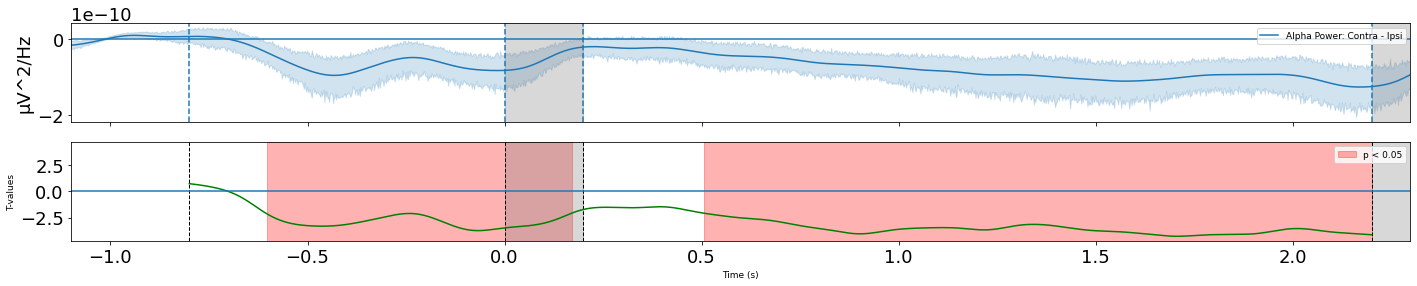

In [34]:
#%% Extract standard alpha (8-13Hz):
frqs_idx = [(8 <= diffs_avgtfr_all[0].freqs) & (diffs_avgtfr_all[0].freqs <= 13)]
diffs_stdalpha_mean = [d.data[:, :, :].mean(axis=(0,1)) for d in diffs_avgtfr_all]

##############################################################################################
# plot it in 2D: 
plt_df = pd.DataFrame(np.array(diffs_stdalpha_mean).swapaxes(1,0), 
                      columns=sub_list_str)
plt_df['time'] = times
plt_df_long = plt_df.melt(id_vars='time', var_name='subID', value_name='pwr')
plt_df_long['hue'] = 'Alpha Power: Contra - Ipsi'

fig, axes = plt.subplots(2, figsize=(24,4), sharex=True)
ax = axes[0]
sns.lineplot(x='time', y='pwr', hue='hue', data=plt_df_long, n_boot=100, ax=ax)
ytick_range = ax.get_ylim()
ax.set(xlim=(-1.1, 2.3), ylim=ytick_range)
ax.set_ylabel('µV^2/Hz')
#ax.set_xlabel('Time (s)')
#ytick_vals = np.arange(*np.round(ytick_range), 2)
#ax.yaxis.set_ticks(ytick_vals)
ax.axvspan(0, 0.2, color='grey', alpha=0.3)
ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
ax.vlines((-0.8, 0, 0.2, 2.2), ymin=ytick_range[0], ymax=ytick_range[1], 
          linestyles='dashed')
ax.hlines(0, xmin=-1.1, xmax=2.3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1, prop={'size': 9})
ax.xaxis.label.set_visible(False)

#%% run CBP test on classical alpha data (sub x times):
# crop to time of interest: 
mask_time = [(times >= -0.8) & (times <= 2.2)]
data = np.array(diffs_stdalpha_mean)[:, mask_time[0]]
T_obs, clusters, c_pvals = run_cbp_test(data, 
                                        p_initial=0.05)


##############################################################################################
# add it to figure:
ax = axes[1]
plot_cbp_result(ax, T_obs, clusters, c_pvals, 0.05, 
                         cbp_times=times[mask_time[0]], 
                         times_full=np.arange(-1.1, 2.3, 0.002))

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'classAlpha_Difference.png')
fig.savefig(fname, bbox_inches="tight")

We write out CSV files with the mean lateralized alpha power per trial so we can read it into R and run our stats there:

In [37]:
#%% Export single trial data about lateral. difference in alpha power 
# for the CDA ROI during the sign cluster:

# For the retention intervall, we look at the 2nd cluster.
cluster_dict = {'name': 'retention', 
                't_start': times[mask_time[0]][clusters[1]][0], 
                't_stop': times[mask_time[0]][clusters[1]][-1]}

mean_pwrdiff_list = list()
for sub in sub_list:
    subID = 'VME_S%02d' % sub
    mean_pwrdiff_df = get_mean_pwrdiff_per_trial(subID, freqs_to_avg=np.arange(8,13), 
                                                 t_start= cluster_dict['t_start'], 
                                                 t_stop= cluster_dict['t_stop'])
    # Write subject data to disk:
    fpath = op.join(config.paths["05_tfrs-summaries"], pwr_style, cluster_dict['name'])
    helpers.chkmk_dir(fpath)
    fname = op.join(fpath, f'{subID}-mean_pwrdiff_{cluster_dict["name"]}.csv')
    mean_pwrdiff_df.to_csv(fname, index=False, float_format="%.25f")
    mean_pwrdiff_list.append(mean_pwrdiff_df)

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S01-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
659 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:   13.1s remaining:   30.6s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:   13.1s remaining:    8.8s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:   13.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.0s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    2.9s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.3s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S02-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
713 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.2s remaining:    2.9s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.0s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S03-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
623 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.2s remaining:    2.9s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.0s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.0s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    2.9s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S04-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
609 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.2s remaining:    2.9s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.4s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S05-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
704 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S06-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
711 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S07-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
704 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S08-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
617 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S09-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
568 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S10-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
705 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S15-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
632 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S16-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
632 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S17-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S18-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
674 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S20-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
598 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S21-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S23-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
701 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S24-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
697 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S25-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
616 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S26-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
662 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S27-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
661 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: IO1, LO1, VEOG, IO2, HEOG, LO2, ECG
[done]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


In [39]:
mean_pwrdiff_all_df = pd.concat(mean_pwrdiff_list)
# Write subject data to disk:
fpath = op.join(config.paths["05_tfrs-summaries"], pwr_style, cluster_dict['name'], 
                'global_summary')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'allsubjects-mean_pwrdiff_{cluster_dict["name"]}.csv')
mean_pwrdiff_all_df.to_csv(fname, index=False, float_format="%.25f")

For each of the main factors, we load the lateralized alpha data into a dataframe. This allows easier plotting. 
!!! This cell runs for pretty long. Afterwards you have the DFs in memory and can efficiently use them.

In [23]:
epo_part = "fulllength"
pwr_style = "induced"
load_df_long = get_condition_pwrdiff_df('Load', cond_dict, sub_list_str, pwr_style=pwr_style, epo_part=epo_part)
ecc_df_long = get_condition_pwrdiff_df('Ecc', cond_dict, sub_list_str, pwr_style=pwr_style, epo_part=epo_part)

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/

Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S07-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptm

Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S07-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S08-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S09-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptm

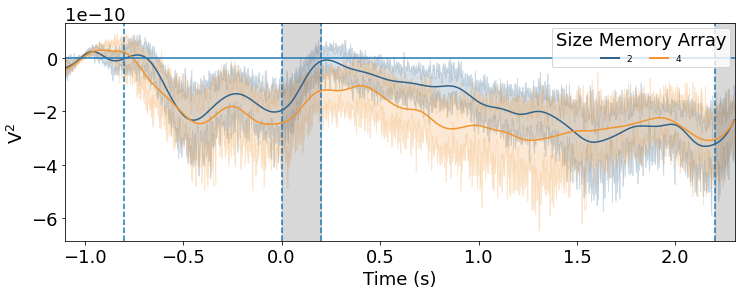

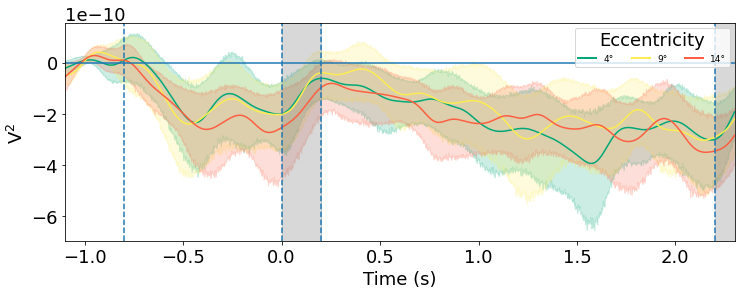

In [25]:
import matplotlib

#Plot main effect Load:
fig, ax = plt.subplots(1, figsize=(12,4))
plot_main_eff('Load', cond_dict, load_df_long, ax, n_boot=1000) # <--- increase "n_boot" for better CIs (takes longer to run)
# Fake legend:
custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['LoadLow'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['LoadHigh'], lw=2)]
ax.legend(handles=custom_lines, title='Size Memory Array', labels=['2', '4'], loc=1, prop={'size': 9}, ncol=2)

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_load.svg')
fig.savefig(fname, bbox_inches="tight")

# Plot main effect Ecc:
fig, ax = plt.subplots(1, figsize=(12,4))
plot_main_eff('Ecc', cond_dict, ecc_df_long, ax, n_boot=1000)
# Fake legend:
custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['EccS'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['EccM'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['EccL'], lw=2)]
ax.legend(handles=custom_lines, title='Eccentricity', labels=['4°', '9°', '14°'], 
          loc=1, prop={'size': 9}, ncol=3)

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_ecc.svg')
fig.savefig(fname, bbox_inches="tight")

## ANOVA
We run a repeated measures ANOVA on the power values (averaged within the bilateral ROIs).
Mostly building on code from [this MNE tutorial](https://mne.tools/dev/auto_tutorials/stats-source-space/plot_stats_cluster_time_frequency_repeated_measures_anova.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-time-frequency-repeated-measures-anova-py).

In [26]:
#%% run rep-meas ANOVA on power: 

# building on code from: 
# https://mne.tools/dev/auto_tutorials/stats-source-space/plot_stats_cluster_time_frequency_repeated_measures_anova.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-time-frequency-repeated-measures-anova-py


#%%
df_list = list()
for load in cond_dict['Load']:
    for ecc in cond_dict['Ecc']:
        tfr_list = [load_avgtfr(subID, load+ecc, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                            -(config.times_dict['cue_dur']+0.1)), 
                    mode='percent') for subID in sub_list_str]


        diffs_ = [get_lateralized_power_difference(tfr, 
                                                config.chans_CDA_dict['Contra'], 
                                                config.chans_CDA_dict['Ipsi']) for 
                tfr in tfr_list]
        for d in diffs_:
            dat_ = d.crop(0.2, 2.2)
            df_list.append(dat_.data.mean(axis=0))
    times = dat_.times
    freqs = dat_.freqs
#%%

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vM

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vM

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S07-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vM

In [27]:
# Setup parameters:
decim = 2
factor_levels = [2, 3]
effects = 'A*B'
n_levels = np.multiply(*factor_levels)
n_freqs = df_list[0].shape[-2]
n_times = df_list[0].shape[-1]
n_subs = int(len(df_list) / n_levels)

# Shape data matrix: subjects x effects x n_freqs*n_times
subtfr_array = np.asarray(df_list)
subtfr_mway_data = subtfr_array.reshape(n_levels, n_subs, n_freqs*n_times)
subtfr_mway_data = subtfr_mway_data.swapaxes(0, 1)

fvals, pvals = f_mway_rm(subtfr_mway_data, factor_levels, effects=effects)
effect_labels = ['Load', 'Ecc', 'Load x Ecc']

In [ ]:
# Plot result:
for effect, sig, effect_label in zip(fvals, pvals, effect_labels):
    f = plt.figure()
    # show naive F-values in gray
    plt.imshow(effect.reshape(n_freqs, n_times), cmap=plt.cm.gray, extent=[times[0],
               times[-1], freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
    # create mask for significant Time-frequency locations
    effect[sig >= 0.05] = np.nan
    plt.imshow(effect.reshape(n_freqs, n_times), cmap='RdBu_r', extent=[times[0],
               times[-1], freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
    cb = plt.colorbar()
    cb.set_label(label='F', rotation=0)
    ytick_range = f.axes[0].get_ylim()
    ytick_vals = np.arange(*np.round(ytick_range), 2)
    f.axes[0].yaxis.set_ticks(ytick_vals)
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(r"Induced lateralized power for '%s' (%s)" % (effect_label, 'CDA-ROI'))
    plt.show()



In [ ]:
# Use CBP test to correct for multiple-comparisons correction:

# We need to do this separately for each effect:
effects='A'

effects_dict = {'A': 'Load',
                'B': 'Eccentricity',
                'A:B': 'Load x Eccentricity'}

def stat_fun(*args):
    return f_mway_rm(np.reshape(args, (len(sub_list), n_levels, n_freqs, len(times))), 
                     factor_levels=factor_levels,
                     effects=effects, return_pvals=False)[0]


# The ANOVA returns a tuple f-values and p-values, we will pick the former.
pthresh = 0.05  # set threshold rather high to save some time
f_thresh = f_threshold_mway_rm(len(sub_list), factor_levels, effects,
                               pthresh)
tail = 1  # f-test, so tail > 0
n_permutations = 1000  # Save some time (the test won't be too sensitive ...)
T_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(
    subtfr_mway_data, stat_fun=stat_fun, threshold=f_thresh, tail=tail, n_jobs=-2,
    n_permutations=n_permutations, buffer_size=None, out_type='mask')

# Plot it:
T_obs_plot = np.ones_like(T_obs) *np.nan
for c, p in zip(clusters, cluster_p_values):
    if p < .05: 
        T_obs_plot[c] = T_obs[c]

f = plt.figure()
for f_image, cmap in zip([T_obs, T_obs_plot], [plt.cm.gray, 'RdBu_r']):
    plt.imshow(f_image.reshape(n_freqs, n_times), cmap=cmap, extent=[times[0], times[-1],
               freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
cb = plt.colorbar()
cb.set_label(label='F', rotation=0)
ytick_range = f.axes[0].get_ylim()
ytick_vals = np.arange(*np.round(ytick_range), 2)
f.axes[0].yaxis.set_ticks(ytick_vals)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f"Induced lateralized power for {effects_dict[effects]} (%s)\n"
          " cluster-level corrected (p <= 0.05)" % 'CDA-ROI')

plt.show()